In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import shutil
import random

# Chemin source où les fichiers audio sont stockés
source_dir = '/content/drive/MyDrive/NAYA_DATA_AUG1X (1)'

# Chemins pour les ensembles d'entraînement et de validation
train_dir = '/content/drive/MyDrive/modelissa/dataset/train'
val_dir = '/content/drive/MyDrive/modelissa/dataset/validation'

# Créer les répertoires s'ils n'existent pas déjà
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Liste des classes
classes = ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind',
           'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']

# Fonction pour répartir les fichiers audio en ensembles d'entraînement et de validation
def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    for class_name in classes:
        # Créer des sous-dossiers pour chaque classe dans train et val
        class_train_dir = os.path.join(train_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)

        # Liste des fichiers audio dans chaque classe
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.exists(class_dir):  # Vérifie si le dossier existe
            print(f"[AVERTISSEMENT] Le dossier {class_name} n'existe pas dans {source_dir}.")
            continue

        audio_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Si aucun fichier n'est trouvé dans le dossier, affiche un avertissement
        if not audio_files:
            print(f"[AVERTISSEMENT] Aucun fichier audio trouvé dans {class_dir}.")
            continue

        random.shuffle(audio_files)  # Mélanger les fichiers

        # Calcul du nombre de fichiers pour l'entraînement
        train_size = int(len(audio_files) * split_ratio)
        train_files = audio_files[:train_size]
        val_files = audio_files[train_size:]

        # Déplacer les fichiers dans les dossiers train et val correspondants
        for file in train_files:
            source_file = os.path.join(class_dir, file)
            destination_file = os.path.join(class_train_dir, file)
            shutil.move(source_file, destination_file)

        for file in val_files:
            source_file = os.path.join(class_dir, file)
            destination_file = os.path.join(class_val_dir, file)
            shutil.move(source_file, destination_file)

        print(f"[INFO] {len(train_files)} fichiers déplacés vers {class_train_dir}")
        print(f"[INFO] {len(val_files)} fichiers déplacés vers {class_val_dir}")

# Appel de la fonction pour organiser les fichiers audio
split_data(source_dir, train_dir, val_dir)
print("Fichiers audio répartis entre les ensembles d'entraînement et de validation.")

[INFO] 480 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/Angry
[INFO] 120 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/validation/Angry
[INFO] 465 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/Defence
[INFO] 117 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/validation/Defence
[INFO] 480 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/Fighting
[INFO] 120 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/validation/Fighting
[INFO] 476 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/Happy
[INFO] 119 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/validation/Happy
[INFO] 462 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/HuntingMind
[INFO] 116 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/validation/HuntingMind
[INFO] 481 fichiers déplacés vers /content/drive/MyDrive/modelissa/dataset/train/Ma

In [ ]:
import os
import numpy as np
import librosa
from skimage.transform import resize  # Pour redimensionner les spectrogrammes
from tqdm import tqdm

# Constantes
SAMPLING_RATE = 16000  # Fréquence d'échantillonnage
DURATION = 29  # Durée cible en secondes
N_MELS = 96  # Nombre de filtres Mel
OUTPUT_SHAPE = (128, 128, 1)  # Forme attendue par le modèle

# Fonction de prétraitement d'un fichier audio
def preprocess_audio_advanced(file_path, output_dir, sampling_rate=SAMPLING_RATE, duration=DURATION, augment=False):
    """
    Prétraite un fichier audio en générant un Mel-spectrogramme redimensionné et normalisé pour être compatible avec le modèle.
    """
    try:
        # Chargement de l'audio
        y, sr = librosa.load(file_path, sr=sampling_rate, mono=True)

        # Zero-padding ou clipping pour atteindre une durée fixe
        target_length = int(sampling_rate * duration)
        if len(y) > target_length:
            y = y[:target_length]
        else:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')

        # Augmentations de données (optionnel)
        if augment:
            if np.random.rand() < 0.5:
                y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))  # Étirement temporel
            if np.random.rand() < 0.5:
                y = librosa.effects.pitch_shift(y=y, sr=sampling_rate, n_steps=np.random.randint(-2, 3))  # Changement de hauteur

        # Calcul du Mel-spectrogramme
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y, sr=sampling_rate, n_mels=N_MELS, fmax=sampling_rate // 2
        )
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Redimensionnement à (128, 128)
        resized_spectrogram = resize(mel_spectrogram, (OUTPUT_SHAPE[0], OUTPUT_SHAPE[1]), mode='constant', anti_aliasing=True)

        # Normalisation entre 0 et 1
        normalized_spectrogram = (resized_spectrogram - np.min(resized_spectrogram)) / (np.max(resized_spectrogram) - np.min(resized_spectrogram))

        # Ajout d'une dimension de canal
        normalized_spectrogram = np.expand_dims(normalized_spectrogram, axis=-1)

        # Normalisation du nom de fichier
        file_name = os.path.basename(file_path).split('.')[0]
        file_name = "".join(c if c.isalnum() or c in "_-" else "_" for c in file_name)
        file_name += "_mel.npy"

        # Sauvegarde du spectrogramme sous forme de fichier .npy
        save_path = os.path.join(output_dir, file_name)
        np.save(save_path, normalized_spectrogram)

    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {str(e)}")

# Fonction de prétraitement pour un répertoire avec sous-dossiers
def preprocess_directory_with_structure(input_dir, output_dir, augment=False):
    """
    Parcourt les sous-dossiers du répertoire d'entrée, traite les fichiers audio et
    les sauvegarde dans une structure de répertoires équivalente dans le répertoire de sortie.
    """
    for subfolder in os.listdir(input_dir):
        subfolder_path = os.path.join(input_dir, subfolder)

        # Vérifier si c'est un dossier
        if os.path.isdir(subfolder_path):
            # Créer le sous-dossier correspondant dans le répertoire de sortie
            output_subfolder = os.path.join(output_dir, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            # Traiter les fichiers audio dans le sous-dossier
            print(f"Traitement des fichiers dans le dossier : {subfolder_path}")
            for file_name in tqdm(os.listdir(subfolder_path)):
                if file_name.lower().endswith(".mp3") or file_name.lower().endswith(".wav"):  # Filtrer les fichiers audio
                    file_path = os.path.join(subfolder_path, file_name)
                    preprocess_audio_advanced(file_path, output_subfolder, augment=augment)

# Répertoires d'entrée et de sortie
train_dir = "/content/drive/MyDrive/modelissa/dataset/train"  # Répertoire des fichiers d'entraînement
val_dir = "/content/drive/MyDrive/modelissa/dataset/validation"  # Répertoire des fichiers de validation
test_dir = "/content/drive/MyDrive/modelissa/dataset/test"  # Répertoire des fichiers de test

output_train_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/train/cnn"  # Répertoire de sortie pour l'entraînement
output_val_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/validation/cnn"  # Répertoire de sortie pour la validation
output_test_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/test/cnn"  # Répertoire de sortie pour le test

# Exécution du prétraitement
if __name__ == "__main__":
    print("Prétraitement de l'ensemble d'entraînement avec augmentations...")
    preprocess_directory_with_structure(train_dir, output_train_dir, augment=True)

    print("Prétraitement de l'ensemble de validation sans augmentations...")
    preprocess_directory_with_structure(val_dir, output_val_dir, augment=False)

    print("Prétraitement de l'ensemble de test sans augmentations...")
    preprocess_directory_with_structure(test_dir, output_test_dir, augment=False)

    print("Prétraitement terminé !")





Prétraitement de l'ensemble d'entraînement avec augmentations...
Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Angry


100%|██████████| 480/480 [02:55<00:00,  2.73it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Defence


100%|██████████| 465/465 [02:31<00:00,  3.07it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Fighting


100%|██████████| 480/480 [02:37<00:00,  3.04it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Happy


100%|██████████| 476/476 [02:33<00:00,  3.09it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/HuntingMind


100%|██████████| 462/462 [02:30<00:00,  3.06it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Mating


100%|██████████| 481/481 [02:36<00:00,  3.07it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/MotherCall


100%|██████████| 473/473 [02:35<00:00,  3.05it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Paining


100%|██████████| 465/465 [02:32<00:00,  3.05it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Resting


100%|██████████| 473/473 [02:36<00:00,  3.02it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/train/Warning


100%|██████████| 480/480 [02:34<00:00,  3.11it/s]


Prétraitement de l'ensemble de validation sans augmentations...
Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Angry


100%|██████████| 120/120 [00:24<00:00,  4.84it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Defence


100%|██████████| 117/117 [00:24<00:00,  4.84it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Fighting


100%|██████████| 120/120 [00:24<00:00,  4.85it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Happy


100%|██████████| 119/119 [00:24<00:00,  4.84it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/HuntingMind


100%|██████████| 116/116 [00:23<00:00,  4.85it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Mating


100%|██████████| 121/121 [00:24<00:00,  4.86it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/MotherCall


100%|██████████| 119/119 [00:24<00:00,  4.85it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Paining


100%|██████████| 117/117 [00:24<00:00,  4.85it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Resting


100%|██████████| 119/119 [00:24<00:00,  4.82it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/validation/Warning


100%|██████████| 120/120 [00:24<00:00,  4.82it/s]


Prétraitement de l'ensemble de test sans augmentations...
Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/MotherCall


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/HuntingMind


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Angry


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Happy


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Mating


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Paining


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Warning


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Fighting


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Resting


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Traitement des fichiers dans le dossier : /content/drive/MyDrive/modelissa/dataset/test/Defence


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

Prétraitement terminé !


Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 151s 945ms/step - accuracy: 0.1518 - loss: 2.4130 - val_accuracy: 0.2138 - val_loss: 2.1254
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.2577 - loss: 1.9775 - val_accuracy: 0.3089 - val_loss: 1.9590
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3956 - loss: 1.6311 - val_accuracy: 0.4907 - val_loss: 1.3608
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5041 - loss: 1.3315 - val_accuracy: 0.5909 - val_loss: 1.1808
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 190s 936ms/step - accuracy: 0.5694 - loss: 1.2018 - val_accuracy: 0.5892 - val_loss: 1.0809
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 206s 961ms/step - accuracy: 0.5907 - loss: 1.1076 - val_accuracy: 0.6145 - val_loss: 1.0252
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 198s 931ms/step - accuracy: 0.6271 - loss: 1.0571 - val_accuracy: 0.6313 - val_loss: 1.0382
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 201s 930ms/step - accuracy: 0.6402 - loss: 1.

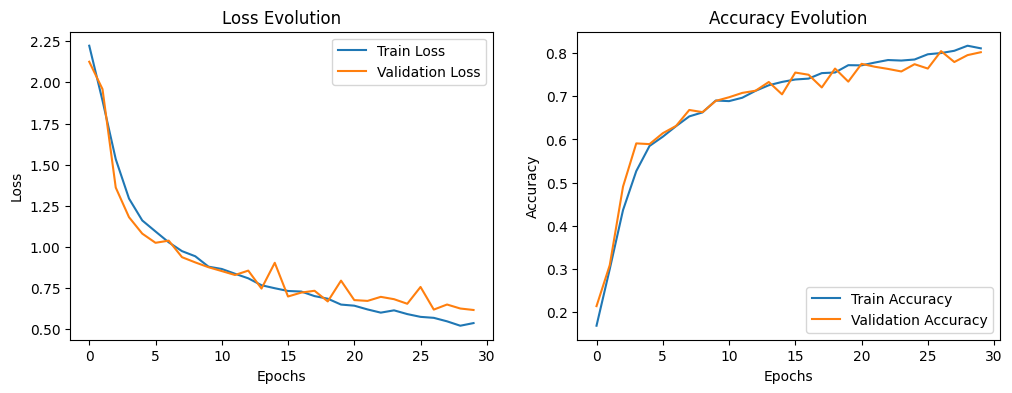

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.7701 - loss: 0.7085
Test Accuracy: 0.73, Test Loss: 0.79
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.70      0.78        10
     Defence       0.73      0.80      0.76        10
    Fighting       0.77      1.00      0.87        10
       Happy       1.00      0.80      0.89        10
 HuntingMind       0.70      0.70      0.70        10
      Mating       0.70      0.70      0.70        10
  MotherCall       0.80      0.80      0.80        10
     Paining       0.60      0.90      0.72        10
     Resting       0.50      0.40      0.44        10
     Warning       0.71      0.50      0.59        10

    accuracy                           0.73       100
   macro avg       0.74      0.73      0.73       100
weighted avg       0.74      0.73      0.73       100



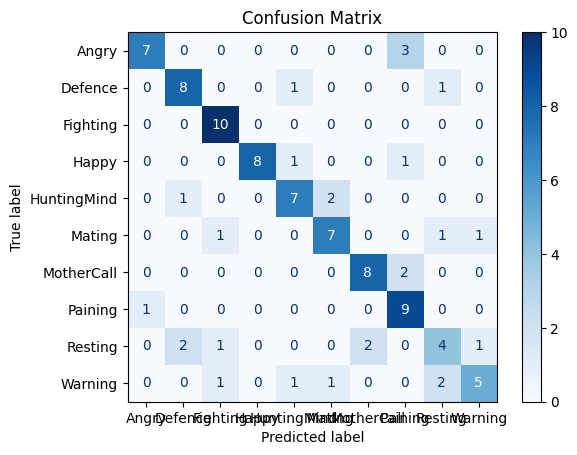

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fonction pour charger les données
def load_data(data_dir, target_shape=(96, 128)):
    """
    Charge les spectrogrammes et les étiquettes depuis un répertoire structuré,
    et ajuste les dimensions pour uniformiser les données.

    Args:
        data_dir (str): Répertoire contenant les sous-dossiers par classe.
        target_shape (tuple): Dimensions cibles des spectrogrammes (H, W).

    Returns:
        tuple: (X, y, label_map), où X est un tableau de spectrogrammes normalisés,
        y est un tableau des étiquettes, et label_map est un dictionnaire de classes.
    """
    X, y = [], []
    label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(data_dir)))}

    for label, idx in label_map.items():
        label_dir = os.path.join(data_dir, label)
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            try:
                spectrogram = np.load(file_path)

                # Vérifier la forme et ajuster si nécessaire
                if spectrogram.shape[0] != target_shape[0]:
                    raise ValueError(f"Hauteur inattendue {spectrogram.shape[0]} pour {file_path}")

                # Ajuster la largeur (recadrage ou remplissage)
                if spectrogram.shape[1] < target_shape[1]:
                    pad_width = target_shape[1] - spectrogram.shape[1]
                    spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
                elif spectrogram.shape[1] > target_shape[1]:
                    spectrogram = spectrogram[:, :target_shape[1]]

                X.append(spectrogram)
                y.append(idx)
            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")

    return np.array(X), np.array(y), label_map

# Répertoires des données
train_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/train/cnn"
val_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/validation/cnn"
test_dir = "/content/drive/MyDrive/modelissa/datasetpreprocessed/test/cnn"

# Chargement des ensembles de données
X_train, y_train, label_map = load_data(train_dir, target_shape=(96, 128))
X_val, y_val, _ = load_data(val_dir, target_shape=(96, 128))
X_test, y_test, _ = load_data(test_dir, target_shape=(96, 128))

# Ajouter une dimension pour le canal (N, H, W, C)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Création du modèle CNN
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialisation du modèle
input_shape = X_train.shape[1:]
num_classes = len(label_map)
model = create_model(input_shape, num_classes)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

# Sauvegarde du modèle
model.save("/content/drive/MyDrive/modelissa/model/cnn_model.h5")

# Visualisation de l'historique d'entraînement
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)

# Évaluation sur le jeu de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

# Prédictions et rapport de classification
y_pred = np.argmax(model.predict(X_test), axis=1)
inv_label_map = {v: k for k, v in label_map.items()}

print("Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=[inv_label_map[i] for i in range(num_classes)]
))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[inv_label_map[i] for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



In [1]:
import tensorflow as tf

# Chemin du modèle sauvegardé
model_path = '/content/drive/MyDrive/modelissa/model/cnn_model.h5'

# Chargement du modèle et affichage du résumé
try:
    # Chargement du modèle sans compilation
    model = tf.keras.models.load_model(model_path, compile=False)

    # Affichage du résumé du modèle
    model.summary()
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 94, 126, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 47, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)